# USING K-MEANS TO GROUP LIGAND BINDING SITES IN CLUSTERS BASED ON THEIR RSA PROFILE

## IMPORTING NECESSARY PACKAGES

In [2]:
from fragsys_analysis import *

In [3]:
def get_rsa_profiles_LOC(bss_df, ress_df):
    """
    Returns a dictionary containint the binding site IDs as keys,
    and the site RSA profile as value. This is a list containing
    the RSA values of the residues forming the site.
    """
    prots = bss_df.protein.unique().tolist()
    rsa_profs = {}
    #rsa_profs_lens = []
    for prot in prots:
        prot_groups = sorted(bss_df.query('protein == @prot').group.unique().tolist())
        for group in prot_groups:
            prot_group_ress = ress_df.query('protein == @prot & group == @group')
            if len(prot_group_ress) == 0:
                print("Group {} of {} has 0 residues. Skipping!".format(group, prot))
                continue
            prot_bs_ids = sorted(bss_df.query('protein == @prot & group == @group').bs_id.unique().tolist())
            for prot_bs_id in prot_bs_ids:
                prot_bs_ress = prot_group_ress[prot_group_ress[prot_bs_id] == 1]
                prot_bs_ress = prot_bs_ress.drop_duplicates(["protein", "UniProt_ResNum", "UniProt_ResName"])
                #rsa_profs_lens.append(len(prot_bs_ress))
                if len(prot_bs_ress) == 0:
                    print("0 res at {} of group {} of {}".format(prot_bs_id, group, prot))
                    continue
                bs_rsas = prot_bs_ress.RSA.tolist()
                dk = "{}_{}_{}".format(prot, group, prot_bs_id)
                rsa_profs[dk] = sorted([round(el, 1) for el in bs_rsas])
    return rsa_profs#, rsa_profs_lens

## READING INPUT DATA

In [4]:
main_dir = "." #"/Users/2394007/Documents/PHD/LOCAL/FRAGSYS_DEF/"
figs_dir = os.path.join(main_dir, "figs")
results_dir = os.path.join(main_dir, "results/new")

all_bs_ress = pd.read_pickle(os.path.join(results_dir, "all_bs_ress.pkl"))
all_bss = pd.read_pickle(os.path.join(results_dir, "all_bss.pkl"))
all_dssp_dfs = pd.read_pickle(os.path.join(results_dir, "all_dssp_dfs.pkl"))

In [5]:
all_bss.head(3)

,bs_id,vars,occ,vars_per_occ,MES,p,norm_shenkin_rel,shenkin_ci,MES_ci,number_bs_res,number_ligs,prop_ligs,protein,group
0,BS0,168,420,0.4,0.2065,0.0281,54.0885,10.6309,0.1831,6,1,1.0000,H0Y4R8,0
1,BS0,24,48,0.5,-0.0623,0.8951,20.8011,9.8766,0.5220,24,14,0.7368,O43809,0
2,BS1,13,26,0.5,-0.0587,1.0000,28.6694,12.4626,0.6883,13,2,0.1053,O43809,0


In [6]:
cc = ["protein", "group", "BS0", "structure", "AA", "SS", "alignment_column", "UniProt_ResName", "UniProt_ResNum", "RSA", "abs_norm_shenkin", "log_oddsratio", "pvalue"] # most informatve columns

In [7]:
round(all_bs_ress, 2)[cc].head(3)

,protein,group,BS0,structure,AA,SS,alignment_column,UniProt_ResName,UniProt_ResNum,RSA,abs_norm_shenkin,log_oddsratio,pvalue
0,H0Y4R8,0,1,5pwc,H,T,79,H,101,63.04,61.50,0.10,0.61
1,H0Y4R8,0,1,5pwc,S,C,85,S,106,39.23,46.22,0.13,0.54
2,H0Y4R8,0,1,5pwc,N,H,317,N,190,41.40,40.64,0.10,0.70


## GETTING RSA DISTRIBUTIONS

In [8]:
rsa_profs = get_rsa_profiles_LOC(all_bss, all_bs_ress)

In [9]:
print(len([len(v) for v in rsa_profs.values()]))

293


In [10]:
for k in list(rsa_profs.keys())[:5]:
    print(k, rsa_profs[k])

H0Y4R8_0_BS0 [22.4, 39.2, 41.4, 46.5, 63.0, 77.7]
O43809_0_BS0 [0.7, 0.7, 0.7, 1.5, 3.0, 4.9, 5.5, 6.8, 8.5, 11.2, 14.4, 15.3, 17.9, 19.4, 19.6, 25.0, 29.9, 30.2, 30.4, 33.0, 33.9, 44.9, 52.1, 78.4]
O43809_0_BS1 [0.4, 7.1, 8.9, 15.8, 20.7, 21.3, 27.4, 37.5, 47.8, 52.8, 63.2, 76.2, 78.9]
O43809_0_BS2 [18.9, 21.0, 25.0, 33.5, 60.1, 63.4, 70.7, 72.7]
O43809_0_BS3 [0.8, 5.9, 12.2, 15.7, 25.0, 33.5, 38.3, 39.7, 43.4, 63.2]


In [10]:
dump_pickle(rsa_profs, os.path.join(results_dir, "rsa_profs.pkl"))

### FILTERING DISTRIBUTIONS ACCORDING TO SITE SIZE

In [11]:
rsa_profs_filt = {k: v for k, v in rsa_profs.items() if len(v) > 1} # filtering out binding sites with a profile shorter than 0 (NONE)
rsa_profs_filt_lens = {k: len(v) for k, v in rsa_profs_filt.items()}
max_len = max(rsa_profs_filt_lens.values())
max_len # maximum RSA profile length, i.e., maximum binding site size

40

In [12]:
rsa_profs_filt_hmap = {k: sorted(v) for k, v in rsa_profs_filt.items()} # this is needed later for the representation of the LBS RSA-based clusters
for k, v in rsa_profs_filt_hmap.items():
    len_v = len(v)
    none_list = [None] * (max_len - len(v))
    v.extend(none_list)

In [13]:
len(rsa_profs_filt)

293

## GETTING UD MATRIX

In [14]:
UD_df = get_UD_matrix(rsa_profs_filt)

In [15]:
labs = UD_df.index.tolist()

In [16]:
UD_df.loc[labs[:5], labs[:5]]

,H0Y4R8_0_BS0,O43809_0_BS0,O43809_0_BS1,O43809_0_BS2,O43809_0_BS3
H0Y4R8_0_BS0,0.000000,0.736111,0.333333,0.125000,0.566667
O43809_0_BS0,0.736111,0.000000,0.352564,0.619792,0.279167
O43809_0_BS1,0.333333,0.352564,0.000000,0.250000,0.146154
O43809_0_BS2,0.125000,0.619792,0.250000,0.000000,0.425000
O43809_0_BS3,0.566667,0.279167,0.146154,0.425000,0.000000


In [17]:
UD_df.to_pickle(os.path.join(results_dir, "UD_df.pkl"))

## IDENTIFYING OPTIMAL K

### ELBOW ANALYSIS

In [17]:
Sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters = k, random_state = 0, n_init = 10)
    km = km.fit(UD_df)
    Sum_of_squared_distances.append(km.inertia_)

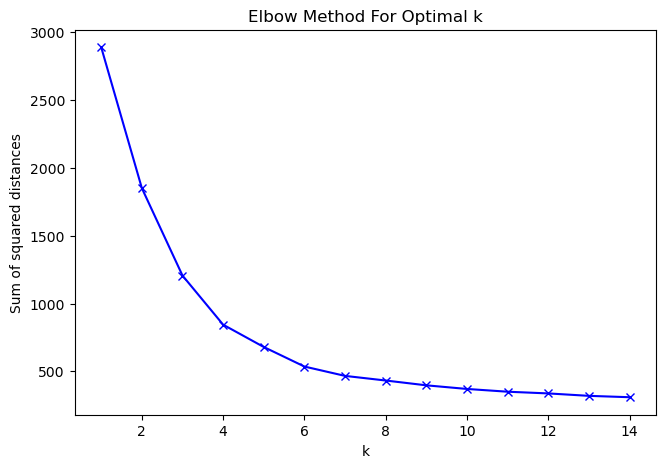

In [18]:
plt.figure(figsize = (7.5, 5), dpi = 100)
plt.plot(K, Sum_of_squared_distances, "bx-")
plt.xlabel("k")
plt.ylabel("Sum of squared distances")
plt.title("Elbow Method For Optimal k")
plt.show()

### SILHOUETTE ANALYSIS

In [19]:
silhouette_avg = []
range_n_clusters = list(range(2,15))
for k in range_n_clusters:

    #initialise kmeans
    km = KMeans(n_clusters = k, random_state = 0, n_init = 10)
    km = km.fit(UD_df)
    cluster_labels = km.labels_

     # silhouette score
    silhouette_avg.append(sklearn.metrics.silhouette_score(UD_df, cluster_labels))

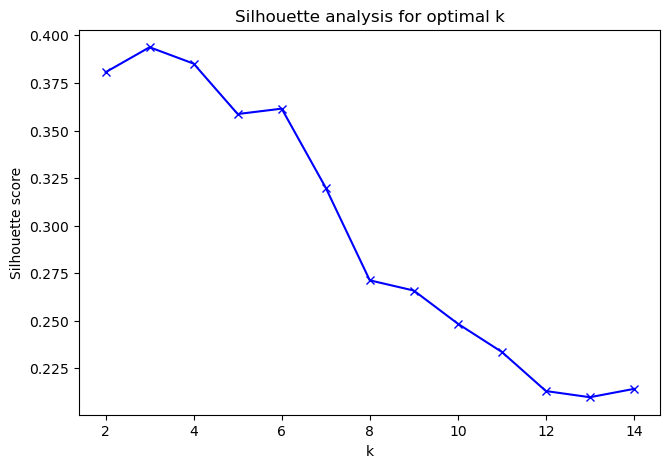

In [20]:
plt.figure(figsize = (7.5, 5), dpi = 100)
plt.plot(range_n_clusters, silhouette_avg, "bx-")
plt.xlabel("k") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis for optimal k")
plt.show()

## CLUSTERING WITH K-MEANS

In [21]:
idx = [i for i in range(len(UD_df)) if rsa_profs_filt_lens[labs[i]] > 1]
idx_labs = [labs[i] for i in idx]
UD_df_subset = UD_df.loc[idx_labs, idx_labs]

UD_array = np.array(UD_df_subset)
rsa_profs_filt_hmap_subset = {k: rsa_profs_filt_hmap[k] for k in idx_labs}
rsa_profs_filt_lens_subset = {k: rsa_profs_filt_lens[k] for k in idx_labs}
max_len = max(list(rsa_profs_filt_lens.values()))

rsa_profs_filt_lens_prop = {k:v/max_len for k,v in rsa_profs_filt_lens.items()}
rsa_profs_filt_lens_prop_subset = {k: rsa_profs_filt_lens_prop[k] for k in idx_labs}

#### K-MEANS CLUSTERING

In [22]:
K = 4

kmeans = KMeans(n_clusters = K, random_state = 0, n_init = 10).fit(UD_array)
kmeans_c_labs = list(kmeans.labels_)
kmeans_cluster_dict = {UD_df_subset.index.tolist()[i]: kmeans_c_labs[i] for i in range(len(kmeans_c_labs))}

In [23]:
renaming_clusters_dict = {0:2, 1:0, 2:3, 3:1}

In [24]:
kmeans_cluster_dict_new = {k:renaming_clusters_dict[v] for k,v in kmeans_cluster_dict.items()}
kmeans_c_labs_new = [renaming_clusters_dict[lab] for lab in kmeans_c_labs]

### VISUALISATION OF THE K-MEANS CLUSTERS - I: BINDING SITES VECTOR REPRESENTATION

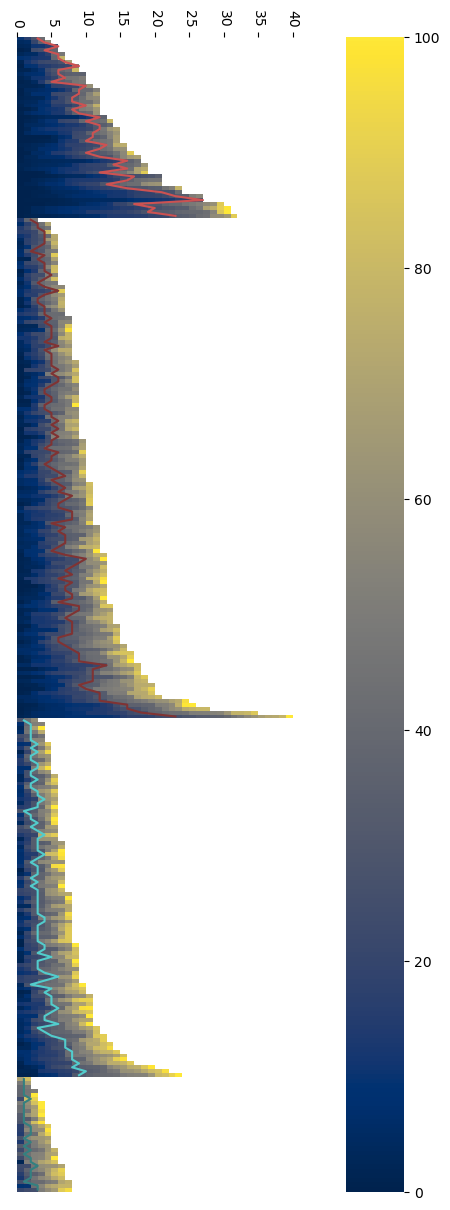

In [25]:
nks = [kmeans_c_labs_new.count(i) for i in range(K)]

plot_clusters(
    rsa_profs_filt_hmap_subset, rsa_profs_filt_lens_subset, kmeans_cluster_dict_new, nks, K, rsa_t = 25,
    fsize = (5, 15), dpi = 100, cmap = "cividis", out = None, show = True, rsa_t_lw = 1.5
)


In [26]:
kmeans_site_color_dict = {k:matplotlib.colors.to_hex(sample_colors[v]) for k, v in kmeans_cluster_dict_new.items()}
un_labs = list(set(kmeans_c_labs_new))
kmeans_membership = {un_lab:[k for k, v in kmeans_cluster_dict_new.items() if v == un_lab] for un_lab in un_labs}

### VISUALISATION OF THE K-MEANS CLUSTERS - II: MULTI DIMENSIONAL SCALING (MDS)

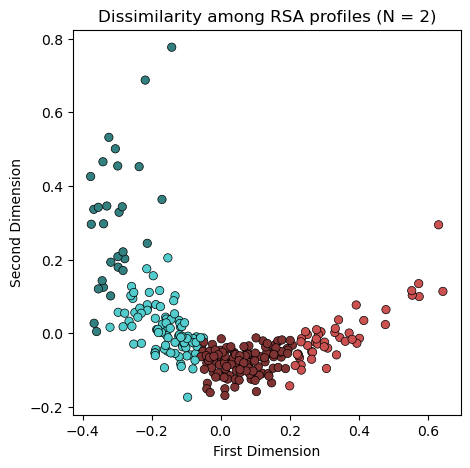

In [27]:
n = 2
cols = list(kmeans_site_color_dict.values())
mds_model = sklearn.manifold.MDS(n_components = n, random_state = 123,
    dissimilarity = 'precomputed', normalized_stress = False)
mds_fit = mds_model.fit(UD_df_subset)  
mds_coords = mds_model.fit_transform(UD_df_subset)

plt.figure(figsize=(5, 5), dpi= 100)
plt.scatter(
        mds_coords[:,0],mds_coords[:,1],
        color = cols, edgecolors = "k", 
        linewidth = 0.5, marker = "o"
        )
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('Dissimilarity among RSA profiles (N = {})'.format(n))

#plt.savefig(os.path.join(main_dir, "figs", "rsa_distrs_kmeans_reordered_n.png".format(n)))

plt.show()

#### SAVE CLUSTER MEMBERSHIP TO FILE

In [53]:
dump_pickle(kmeans_membership, os.path.join(results_dir, "rsa_cluster_membership.pkl"))

In [28]:
rsa_cluster_dict = {v1: k for k, v in kmeans_membership.items() for v1 in v}

In [55]:
dump_pickle(rsa_cluster_dict, os.path.join(results_dir, "rsa_cluster_dict.pkl"))

In [31]:
kmeans_cluster_dict_new == rsa_cluster_dict

True